In [106]:
import konlpy
import gensim

import pandas as pd


## 목표  
  
1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.  
3가지 이상의 모델이 성공적으로 시도됨  
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.  
gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함  
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.  
네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함  

### 데이터 준비와 확인

In [107]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [108]:
len(train_data)

150000

In [109]:
len(test_data)

50000

In [110]:
train_data['document']

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 150000, dtype: object

데이터의 갯수가 엄청남을 확인할 수 있습니다  
구성은 간단하게 label과 문장으로 되어있습니다  


### 데이터 로더 구성

중복되는 데이터 제거  
NAN 결측치 제거  
한국어 토크나이저로 토큰화  
불용어 (stopwords) 제거  
사전 word to index 구성  
텍스트 스트링을 인덱스 스트링으로 변환  
X_train, Y_train, X_test, Y_test, word to index를 리턴하는 데이터 로더를 구성합니다 

전반적으로 EDA과정과 같습니다  

In [111]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000 

In [129]:
def load_data(train_data, test_data, num_words=num_words):
    
    
    #중복되는 데이터 제거 / NAN 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ["<PAD>", "<BOS>", "<UNK>", "<UNUSED>"] + [key for key, _ in counter]

    #사전 word to index 구성
    word_to_index = {word:index for index, word in enumerate(vocab)}    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index["<PAD>"] for word in wordlist]
    
    #텍스트 스트링을 인덱스 스트링으로 변환하여 train data, test data에 할당합니다 
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    

In [130]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [131]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [133]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 모델 구성을 위한 데이터 분석 및 가공  
데이터셋 내 문장 길이 분포  
적절한 최대 문장 길이 지정  
keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가  

단어 분포 확인

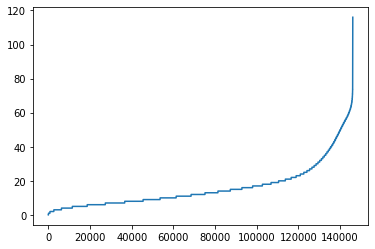

In [134]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

len_dist = []
i = 0
for sentence in X_train:
    len_dist.append(len(sentence))

len_dist.sort()
plt.plot(len_dist)

#https://www.programiz.com/python-programming/methods/list/sort
#https://www.programiz.com/python-programming/methods/list/sort

In [135]:
pd.DataFrame(len_dist).describe()

,0
count,146182.000000
mean,15.981708
std,12.824782
min,0.000000
25%,7.000000
50%,12.000000
75%,19.000000
max,116.000000


단어 갯수의 평균은 12, 19개 까지가 75%를 차지하고 있습니다  
그래프 상으로는 단어 갯수 40개 정도 전후로 가파른 상승을 보여줍니다  

In [136]:
len_dist.index(40)

135488

대략 8% 정도 (전체 146182 - 135488) 가 40개 정도의 단어를 쓰고 있습니다  
이 정도로 단어의 최대 갯수를 제한합니다  

In [137]:
import tensorflow as tf

maxlen = 40

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)


### 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.  
  
처음 모델로 RNN을 사용합니다

### RNN

In [191]:
#RNN LSTM GRU 사용

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


데이터의 20%를 데이터 검증셋으로 사용하도록 합니다

In [192]:
val_count = int(len(y_train) * 0.20)

x_val = X_train[:val_count]   
y_val = y_train[:val_count]

partial_x_train = X_train[val_count:]  
partial_y_train = y_train[val_count:]

In [193]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 7ms/step - loss: 0.4993 - accuracy: 0.7782 - val_loss: 0.3615 - val_accuracy: 0.8457
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3396 - accuracy: 0.8565 - val_loss: 0.3448 - val_accuracy: 0.8496
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3164 - accuracy: 0.8682 - val_loss: 0.3459 - val_accuracy: 0.8505
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3041 - accuracy: 0.8733 - val_loss: 0.3553 - val_accuracy: 0.8493
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2940 - accuracy: 0.8777 - val_loss: 0.3459 - val_accuracy: 0.8526
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2852 - accuracy: 0.8819 - val_loss: 0.3473 - val_accuracy: 0.8528
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2746 - accuracy: 0.8864 - val_loss: 0.3502 - val_accuracy: 0.8523
Epoch 

In [194]:
results = model.evaluate(x_val,  y_val, verbose=2)

print(results)

914/914 - 2s - loss: 0.5516 - accuracy: 0.8408
[0.5516163110733032, 0.8408126831054688]


In [195]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


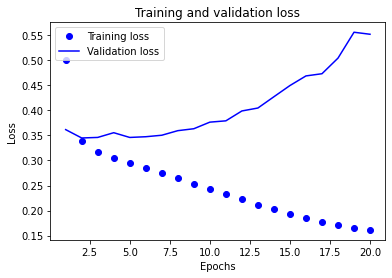

In [196]:


acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

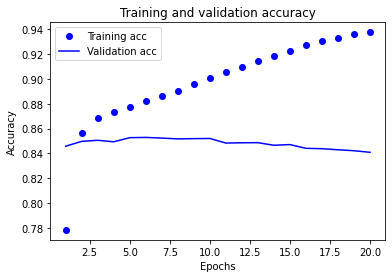

In [197]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [198]:
y_pred = model.predict(X_test)

In [199]:
y_pred

array([[9.7733468e-01],
       [4.9031717e-01],
       [6.5619749e-01],
       ...,
       [1.0189637e-01],
       [5.2774125e-05],
       [2.4412226e-02]], dtype=float32)

결과는 ~%의 정도로 긍정적임 을 나타내는 것으로 보입니다  
0.5 이상이면 긍정으로 봐도 될까요?  
이 수치를 threshold로 위아래로 구분하여 이진화시키면, 얼마나 비슷한 prediction을 했는지 알 수 있을 것 같습니다  

In [200]:
for i in range(len(y_pred)):
    if(y_pred[i] > 0.5):
        y_pred[i] = 1
    else:
        y_pred[i] = 0

y_pred

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [201]:
#http://www.gisdeveloper.co.kr/?p=9932 참고

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cf = confusion_matrix(y_test, y_pred)
cf



array([[20430,  4016],
       [ 4007, 20704]])

In [202]:
a = accuracy_score(y_test, y_pred)
a

0.8367882498931993

예측이 정답과 정확한가를 보여주는 accuracy는 83%

In [203]:
p = precision_score(y_test, y_pred)
p

0.8375404530744337

예측한 것들중에 정답의 비율을 보여주는 정밀도 precision은 83%을 보여줍니다

In [204]:
r = recall_score(y_test, y_pred)
r

0.837845493909595

재현률 또한 84%를 보여줬습니다 (찾아야 할 것들 중 실제로 찾은 비율)

In [205]:
f1 = f1_score(y_test, y_pred)
f1

0.8376929457223201

f1_score가 84%라고 하면, 성능이 낮지는 않다고 할 수 있겠습니다만, 개선의 여지가 충분히 있습니다

### CNN  
NLP에서도 CNN이 이진 분류 성능이 좋다고 했습니다  
테스트 해봅니다  

In [206]:

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 8, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(4))
model2.add(tf.keras.layers.Conv1D(16, 8, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 16)          2064      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 16)          2064      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [207]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 2s 6ms/step - loss: 0.5208 - accuracy: 0.7382 - val_loss: 0.3760 - val_accuracy: 0.8318
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3505 - accuracy: 0.8469 - val_loss: 0.3585 - val_accuracy: 0.8413
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3212 - accuracy: 0.8637 - val_loss: 0.3575 - val_accuracy: 0.8431
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2985 - accuracy: 0.8747 - val_loss: 0.3563 - val_accuracy: 0.8431
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2758 - accuracy: 0.8865 - val_loss: 0.3616 - val_accuracy: 0.8427
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2487 - accuracy: 0.9004 - val_loss: 0.3752 - val_accuracy: 0.8413
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2190 - accuracy: 0.9154 - val_loss: 0.4007 - val_accuracy: 0.8371
Epoch 

In [208]:
results2 = model2.evaluate(x_val,  y_val, verbose=2)

print(results2)

914/914 - 1s - loss: 0.9032 - accuracy: 0.8130
[0.9032433032989502, 0.8129703402519226]


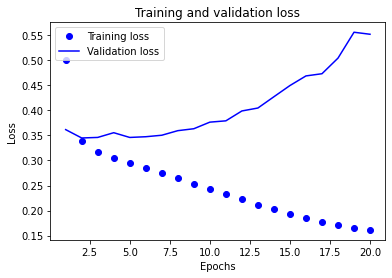

In [209]:
history_dict2 = history.history

acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

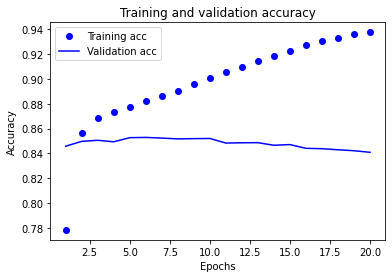

In [210]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

training acc가 엄청 높은것에 비해 val acc와 격차가 큽니다  
엄청난 오버피팅이 일어났습니다  
  
프레딕션을 진행해보겠습니다  

In [211]:
y_pred2 = model2.predict(X_test)

In [212]:
#마찬가지로 이진분류를 위해 작업합니다
for i in range(len(y_pred2)):
    if(y_pred2[i] > 0.5):
        y_pred2[i] = 1
    else:
        y_pred2[i] = 0

In [214]:
cf = confusion_matrix(y_test, y_pred2)
a = accuracy_score(y_test, y_pred2)
p = precision_score(y_test, y_pred2)
r = recall_score(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2)

In [216]:

print("confution matrix")
print(cf)
print()
print("accuracy : ", a)
print("precision score : ", p)
print("recall score : ", r)
print("f1_score : ", f1)

confution matrix
[[19756  4690]
 [ 4776 19935]]

accuracy :  0.8074333258742397
precision score :  0.8095431472081218
recall score :  0.8067257496661406
f1_score :  0.8081319928652506


CNN의 train / test 속도는 체감상 더 빨랐지만, 성능은  RNN보다 전체적으로 떨어집니다

### CNN - Maxpooling 1D  
Convolution 과정을 생략합니다  
이 과정이 의외로 성능이 좋을수도 있다고 하여 기대됩니다  

In [217]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [219]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 1s 4ms/step - loss: 0.5874 - accuracy: 0.7746 - val_loss: 0.4410 - val_accuracy: 0.8157
Epoch 2/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3873 - accuracy: 0.8367 - val_loss: 0.3670 - val_accuracy: 0.8383
Epoch 3/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3343 - accuracy: 0.8589 - val_loss: 0.3524 - val_accuracy: 0.8451
Epoch 4/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3056 - accuracy: 0.8727 - val_loss: 0.3499 - val_accuracy: 0.8480
Epoch 5/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2847 - accuracy: 0.8829 - val_loss: 0.3519 - val_accuracy: 0.8458
Epoch 6/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2676 - accuracy: 0.8918 - val_loss: 0.3574 - val_accuracy: 0.8469
Epoch 7/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2532 - accuracy: 0.8992 - val_loss: 0.3655 - val_accuracy: 0.8454
Epoch 

In [220]:
results3 = model3.evaluate(x_val,  y_val, verbose=2)

print(results3)

914/914 - 1s - loss: 0.5085 - accuracy: 0.8316
[0.508488118648529, 0.831577479839325]


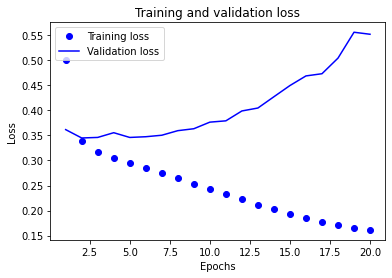

In [221]:
history_dict3 = history.history

acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

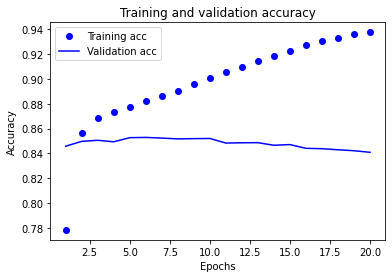

In [222]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

일반 CNN와 마찬가지로 overfittig이 일어났습니다  
양측 그래프 추이를 보아하니 validation의 상승이 일어나지 않습니다  
validation이 training시 parameter에 영향을 끼지지 못하는 듯 합니다  

In [223]:
y_pred3 = model3.predict(X_test)

In [224]:
#마찬가지로 이진분류를 위해 작업합니다
for i in range(len(y_pred3)):
    if(y_pred3[i] > 0.5):
        y_pred3[i] = 1
    else:
        y_pred3[i] = 0

In [225]:
cf = confusion_matrix(y_test, y_pred3)
a = accuracy_score(y_test, y_pred3)
p = precision_score(y_test, y_pred3)
r = recall_score(y_test, y_pred3)
f1 = f1_score(y_test, y_pred3)

In [226]:

print("confution matrix")
print(cf)
print()
print("accuracy : ", a)
print("precision score : ", p)
print("recall score : ", r)
print("f1_score : ", f1)

confution matrix
[[20243  4203]
 [ 4315 20396]]

accuracy :  0.8267184734625791
precision score :  0.8291393959104029
recall score :  0.8253814090890697
f1_score :  0.8272561346582843


일반 CNN보다는 약간의 성능이 올라갔습니다만, RNN에 비하면 성능이 부족한 듯 합니다

## 회고  
  
일정관리를 하지 못해 프로젝트를 충분히 진행하지 못했습니다 많이 속상합니다  
CV쪽에 관심이 막대하고, NLP쪽은 아무리해도 익숙하지 않아 이번 제출을 포기할까 했지만, 
한번 포기하기 시작하면 쭉 NLP에 관심을 가지지 않을 것 같아, 개인적으로는 무리해서 진행하게 되었습니다  
  
프로젝트를 하면서, 아직 복습할 것들이 많이 남았지만  NLP쪽에 대해 더 배우게 되고  
또 해당분야에 가지던 막연한 두려움 또한 조금 극복한 듯 합니다  
  
### 개선사항 꼭 지키겠습니다  
모델의 parameter를 바꾸어 학습  
디테일한 전처리  
여러 모델의 테스트 결과를 동시에 비교하는 평가  
genism 및 word2vec의 활용  


In [126]:
#추후에 진행할 내용

In [103]:
import re

#train_data['Refined'] = [re.sub('[^A-Za-z0-9가-힣]', '', s) for s in train_data['document']]
#test_data['Refined'] = [re.sub('[^A-Za-z0-9가-힣]', '', s) for s in train_data['document']]

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
#    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
#    sentence = re.sub(r'[" "]+', " ", sentence) # 3
#    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = re.sub(r"[^A-Za-z0-9가-힣]", " ", sentence)
    sentence = re.sub('  ',' ' , sentence)
    sentence = sentence.strip() # 5
#    sentence = ' <start> ' + sentence + ' <end> ' # 6
    return sentence


type(train_data['document'].values)
tmp = train_data['document'].values

tmp2 = []
for s in tmp:
    tmp2.append(preprocess_sentence(str(s)))

tmp2



#https://signing.tistory.com/74 참고

['아 더빙  진짜 짜증나네요 목소리',
 '흠  포스터보고 초딩영화줄  오버연기조차 가볍지 않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼  솔직히 재미는 없다 평점 조정',
 '사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다',
 '막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화    별반개도 아까움',
 '원작의 긴장감을 제대로 살려내지못했다',
 '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지 정말 발로해도 그것보단 낫겟다 납치 감금만반복반복 이드라마는 가족도없다 연기못하는사람만모엿네',
 '액션이 없는데도 재미 있는 몇안되는 영화',
 '왜케 평점이 낮은건데 꽤 볼만한데  헐리우드식 화려함에만 너무 길들여져 있나',
 '걍인피니트가짱이다 진짜짱이다',
 '볼때마다 눈물나서 죽겠다90년대의 향수자극 허진호는 감성절제멜로의 달인이다',
 '울면서 손들고 횡단보도 건널때 뛰쳐나올뻔 이범수 연기 드럽게못해',
 '담백하고 깔끔해서 좋다 신문기사로만 보다 보면 자꾸 잊어버린다 그들도 사람이었다는 것을',
 '취향은 존중한다지만 진짜 내생에 극장에서 본 영화중 가장 노잼 노감동임 스토리도 어거지고 감동도 어거지',
 '냥 매번 긴장되고 재밋음',
 '참 사람들 웃긴게 바스코가 이기면 락스코라고 까고바비가 이기면 아이돌이라고 깐다 그냥 까고싶어서 안달난것처럼 보인다',
 '굿바이 레닌 표절인것은 이해하는데 왜 뒤로 갈수록 재미없어지냐',
 '이건 정말 깨알 캐스팅과 질퍽하지않은 산뜻한 내용구성이 잘 버무러진 깨알일드',
 '약탈자를 위한 변명 이라 저놈들은 착한놈들 절대 아닌걸요',
 '나름 심오한 뜻도 있는 듯 그냥 학생이 선생과 놀아나는 영화는 절대 아님',
 '보면서 웃지 않는 건 불가능하다',
 '재미없다 지루하고 같은 음식 영화인데도 바베트의 만찬하고 넘 차이남  바베트의 만찬은 이야기도 있고 음식 보는재미도 있는데  이건 볼게없다 음식도 별로 안나오고

In [104]:
train_data['clean_doc'] = tmp2
train_data['clean_doc']

0                                        아 더빙  진짜 짜증나네요 목소리
1                            흠  포스터보고 초딩영화줄  오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                               교도소 이야기구먼  솔직히 재미는 없다 평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                     인간이 문제지  소는 뭔죄인가
149996                                           평점이 너무 낮아서
149997                        이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다
149998                          청춘 영화의 최고봉 방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: clean_doc, Length: 150000, dtype: object